# Mask R-CNN - Train on Shapes Dataset

### Compare ouptuts from Heatmap layer and FCN layer


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import math
import re
import  gc
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

import keras.backend as KB
sys.path.append('../')

import mrcnn.model     as modellib
import mrcnn.visualize as visualize
import mrcnn.shapes    as shapes
from mrcnn.config      import Config
from mrcnn.model       import log
from mrcnn.dataset     import Dataset 

from mrcnn.utils       import stack_tensors, stack_tensors_3d
from mrcnn.datagen     import data_generator, load_image_gt
from mrcnn.callbacks   import get_layer_output_1,get_layer_output_2
from mrcnn.visualize   import plot_gaussian
# from mrcnn.pc_layer    import PCTensor
# from mrcnn.pc_layer   import PCNLayer

# Root directory of the project
ROOT_DIR = os.getcwd()
MODEL_PATH = 'E:\Models'
# Directory to save logs and trained model
MODEL_DIR = os.path.join(MODEL_PATH, "mrcnn_logs")
# Path to COCO trained weights
COCO_MODEL_PATH   = os.path.join(MODEL_PATH, "mask_rcnn_coco.h5")
RESNET_MODEL_PATH = os.path.join(MODEL_PATH, "resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

print("Tensorflow Version: {}   Keras Version : {} ".format(tf.__version__,keras.__version__))
import pprint
pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4)


# Build configuration object -----------------------------------------------
config = shapes.ShapesConfig()
config.BATCH_SIZE      = 5                  # Batch size is 2 (# GPUs * images/GPU).
config.IMAGES_PER_GPU  = 5                  # Must match BATCH_SIZE
config.STEPS_PER_EPOCH = 2
config.FCN_INPUT_SHAPE = config.IMAGE_SHAPE[0:2]
# config.display() 

# Build shape dataset        -----------------------------------------------
# Training dataset
# generate 500 shapes 
dataset_train = shapes.ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = shapes.ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

try :
    del model, train_generator, val_generator, mm
    gc.collect()
except: 
    pass
# Load and display random samples
# image_ids = np.random.choice(dataset_train.image_ids, 3)
# for image_id in [3]:
#     image = dataset_train.load_image(image_id)
#     mask, class_ids = dataset_train.load_mask(image_id)
#     visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
print(' COCO Model Path       : ', COCO_MODEL_PATH)
print(' Checkpoint folder Path: ', MODEL_DIR)
print(MODEL_PATH)
print(COCO_MODEL_PATH)
print(RESNET_MODEL_PATH)
print(MODEL_DIR)


D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Tensorflow Version: 1.6.0   Keras Version : 2.1.4 
 Initialize config object - super
 COCO Model Path       :  E:\Models\mask_rcnn_coco.h5
 Checkpoint folder Path:  E:\Models\mrcnn_logs
E:\Models
E:\Models\mask_rcnn_coco.h5
E:\Models\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
E:\Models\mrcnn_logs


# Create Model

In [2]:
try :
    del model
    print('delete model is successful')
    gc.collect()
except: 
    pass
KB.clear_session()
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

    set_log_dir: Checkpoint path set to : E:\Models\mrcnn_logs\shapes20180503T1639\mask_rcnn_shapes_{epoch:04d}.h5
    set_log_dir: self.epoch set to 0 

>>> Resnet Graph 
     Input_image shape : (?, 128, 128, 3)
     After ZeroPadding2D  : (?, 134, 134, 3) (?, 134, 134, 3)
     After Conv2D padding : (?, 64, 64, 64) (?, 64, 64, 64)
     After BatchNorm      : (?, 64, 64, 64) (?, 64, 64, 64)
     After MaxPooling2D   : (?, 32, 32, 64) (?, 32, 32, 64)

>>> Feature Pyramid Network (FPN) Graph 
     FPN P2 shape : (None, 32, 32, 256)
     FPN P3 shape : (None, 16, 16, 256)
     FPN P4 shape : (None, 8, 8, 256)
     FPN P5 shape : (None, 4, 4, 256)
     FPN P6 shape : (None, 2, 2, 256)

>>> RPN Layer 
     Input_feature_map shape : (?, ?, ?, 256)
     anchors_per_location    : 3
     depth                   : 256
     Input_feature_map shape : (?, ?, ?, 256)
     anchors_per_location    : 3
     anchor_stride           : 1

>>> RPN Outputs  <class 'list'>
      rpn_class_logits/concat:0
 

    after transpose  (128, 128, 5, 32, 2)
    pt2_sum shape  (5, 4, 32)
    dense shape  (?, 6)
    Build Stacked output from dynamically partitioned lists --------------
    >> input to MVN.PROB: pos_grid (meshgrid) shape:  (128, 128, 5, 32, 2)
    << output probabilities shape: (5, 32, 128, 128)

    Scatter out the probability distributions based on class --------------
    gaussian_grid      :  (5, 32, 128, 128)
    class shape        :  (5, ?)
    roi_grid shape     :  (5, 32)
    batch_grid shape   :  (5, 32)
    scatter_classes    :  (5, 32, 3)
    gaussian scattered :  (5, 4, 32, 128, 128)

    Reduce sum based on class ---------------------------------------------
    gaussian sum type/name :  <class 'tensorflow.python.framework.ops.Tensor'> cntxt_layer/pred_gaussian_1:0 pred_gaussian
    gaussian_sum shape     :  (5, 128, 128, 4) Keras tensor  False

 
  > BUILD_GAUSSIAN_TF() for  ['gt_gaussian']
    orignal in_tensor shape :  (5, 4, 100, 6)
    modified in_tensor shape :  (5

    loss type is : <class 'tensorflow.python.framework.ops.Tensor'>

 Keras Tensors?? 
 pred_gaussian : True
 gt_gaussian   : True
 mask_loss     : True
 rpn_rois      : True
 fcn_loss      : True
 fcn_norm_loss : True
>>> MaskRCNN build complete
>>> MaskRCNN initialization complete


In [3]:
print(model.find_last())
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
#     loc=model.load_weights(model.get_imagenet_weights(), by_name=True)
    loc=model.load_weights(RESNET_MODEL_PATH, by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    
    # See README for instructions to download the COCO weights
    loc=model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    loc= model.load_weights(model.find_last()[1], by_name=True)
print('Load weights complete')

('E:\\Models\\mrcnn_logs\\shapes20180428T1819', 'E:\\Models\\mrcnn_logs\\shapes20180428T1819\\mask_rcnn_shapes_5784.h5')
>>> load_weights()
    load_weights: Loading weights from: E:\Models\mrcnn_logs\shapes20180428T1819\mask_rcnn_shapes_5784.h5
    load_weights: Log directory set to : E:\Models\mrcnn_logs\shapes20180428T1819\mask_rcnn_shapes_5784.h5
    set_log_dir: Checkpoint path set to : E:\Models\mrcnn_logs\shapes20180428T1819\mask_rcnn_shapes_{epoch:04d}.h5
    set_log_dir: self.epoch set to 5785 
    Load weights complete :  E:\Models\mrcnn_logs\shapes20180428T1819\mask_rcnn_shapes_5784.h5
Load weights complete


###  Print some model information 

In [4]:
#model.keras_model.summary(line_length = 120) 
# model.compile_only(learning_rate=config.LEARNING_RATE, layers='heads')
# KB.set_learning_phase(1)
print('\n Outputs: ') 
pp.pprint(model.keras_model.outputs)
print('\n Losses (model.metrics_names): ') 
# pp.pprint(model.keras_model.metrics_names)


 Outputs: 
[ <tf.Tensor 'output_rois/mul:0' shape=(5, ?, ?) dtype=float32>,
  <tf.Tensor 'proposal_targets/target_class_ids:0' shape=(5, ?) dtype=int32>,
  <tf.Tensor 'proposal_targets/target_bbox_deltas:0' shape=(5, ?, ?) dtype=float32>,
  <tf.Tensor 'proposal_targets/target_mask:0' shape=(5, ?, ?, ?) dtype=float32>,
  <tf.Tensor 'rpn_class_logits/concat:0' shape=(?, ?, 2) dtype=float32>,
  <tf.Tensor 'proposal_rois/packed_2:0' shape=(5, ?, ?) dtype=float32>,
  <tf.Tensor 'rpn_class/concat:0' shape=(?, ?, 2) dtype=float32>,
  <tf.Tensor 'rpn_bbox/concat:0' shape=(?, ?, 4) dtype=float32>,
  <tf.Tensor 'mrcnn_class_logits/Reshape_1:0' shape=(?, 32, 4) dtype=float32>,
  <tf.Tensor 'mrcnn_class/Reshape_1:0' shape=(?, 32, 4) dtype=float32>,
  <tf.Tensor 'mrcnn_bbox/Reshape:0' shape=(?, 32, 4, 4) dtype=float32>,
  <tf.Tensor 'mrcnn_mask/Reshape_1:0' shape=(?, 32, 28, 28, 4) dtype=float32>,
  <tf.Tensor 'fcn_bilinear/ResizeBilinear:0' shape=(5, 128, 128, 4) dtype=float32>,
  <tf.Tensor 'rpn

In [5]:
# model.keras_model.summary(line_length = 150) 

### Define Data Generator

In [6]:
train_generator = data_generator(dataset_train, model.config, shuffle=True,
                                 batch_size=model.config.BATCH_SIZE,
                                 augment = False)
val_generator = data_generator(dataset_val, model.config, shuffle=True, 
                                batch_size=model.config.BATCH_SIZE,
                                augment=False)

### Get next shapes from generator and display loaded shapes

In [7]:
train_batch_x, train_batch_y = next(train_generator)

1
Image id:  132
Image meta [132 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [2 2]


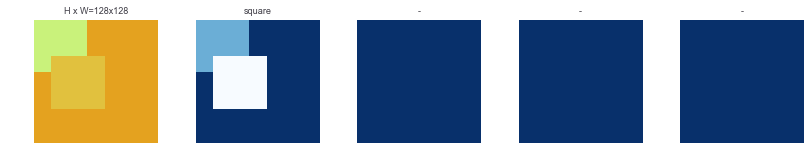

Image id:  116
Image meta [116 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [1 2]


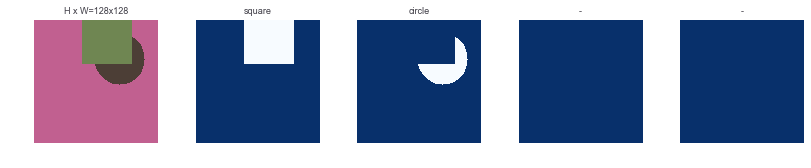

Image id:  109
Image meta [109 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [3 3]


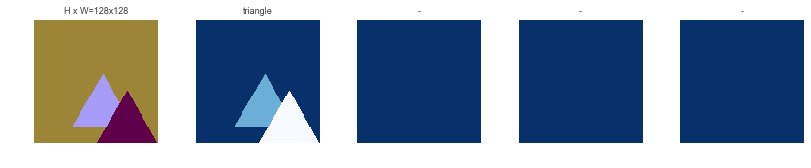

Image id:  294
Image meta [294 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [3 1]


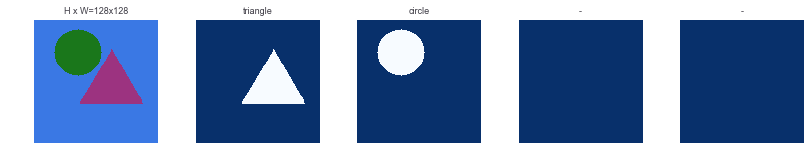

Image id:  448
Image meta [448 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [1 2 3 3]


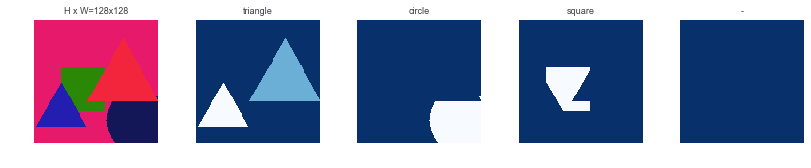

In [8]:
# train_batch_x, train_batch_y = next(train_generator)
imgmeta_idx = model.keras_model.input_names.index('input_image_meta')
print(imgmeta_idx)
img_meta    = train_batch_x[imgmeta_idx]

for img_idx in range(config.BATCH_SIZE):
    image_id = img_meta[img_idx,0]
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print('Image id: ',image_id)
    print('Image meta', img_meta[img_idx])
    print('Classes (1: circle, 2: square, 3: triangle ): ',class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)



### Push Data thru model using get_layer_output()

In [ ]:

layers_out = get_layer_output_2(model.keras_model, train_batch_x, 1)


/* Inputs */
Input 0:  (input_image             ) 	  Input shape: (5, 128, 128, 3)
Input 1:  (input_image_meta        ) 	  Input shape: (5, 12)
Input 2:  (input_rpn_match         ) 	  Input shape: (5, 4092, 1)
Input 3:  (input_rpn_bbox          ) 	  Input shape: (5, 256, 4)
Input 4:  (input_gt_class_ids      ) 	  Input shape: (5, 100)
Input 5:  (input_gt_boxes          ) 	  Input shape: (5, 100, 4)
Input 6:  (input_gt_masks          ) 	  Input shape: (5, 56, 56, 100)


In [ ]:
sess=  tf.InteractiveSession()

###  Compute mean/min/max of Pred/GT gaussian tensors and FCN output

In [ ]:
fcn_masks  = tf.identity(layers_out[12])
pred_masks = tf.identity(layers_out[18])
gt_masks   = tf.identity(layers_out[19])
shape = KB.int_shape(pred_masks)
print(shape)

pred_masks_r = tf.reshape(pred_masks, [shape[0], -1, shape[-1]])
fcn_masks_r = tf.reshape(fcn_masks, [shape[0], -1, shape[-1]])
gt_masks_r  = tf.reshape(gt_masks, [shape[0], -1, shape[-1]])

print(gt_masks_r.shape, fcn_masks_r.shape)

pred_mean2 = KB.mean(pred_masks_r, axis = 1).eval()
pred_max2  =  KB.max(pred_masks_r, axis=1).eval()
pred_min2  =  KB.min(pred_masks_r, axis=1).eval()

gt_mean2 = KB.mean(gt_masks_r, axis = 1).eval()
gt_max2  =  KB.max(gt_masks_r, axis=1).eval()
gt_min2  =  KB.min(gt_masks_r, axis=1).eval()

fcn_mean2 = KB.mean(fcn_masks_r, axis = 1).eval()
fcn_max2  =  KB.max(fcn_masks_r, axis=1).eval()
fcn_min2  =  KB.min(fcn_masks_r, axis=1).eval()        

### Compute L2 Normalizationof Pred, GT, and FCN tensors

In [ ]:
pred_l2      = KB.l2_normalize(pred_masks_r, axis = 1)
gt_l2        = KB.l2_normalize(gt_masks_r, axis = 1)
fcn_l2       = KB.l2_normalize(fcn_masks_r, axis = 1)
pred_l2_min  = KB.min(pred_l2, axis = 1).eval()
pred_l2_max  = KB.max(pred_l2, axis = 1).eval()
pred_l2_mean = KB.mean(pred_l2, axis = 1).eval()
gt_l2_min    = KB.min(gt_l2, axis = 1).eval()
gt_l2_max    = KB.max(gt_l2, axis = 1).eval()
gt_l2_mean   = KB.mean(gt_l2, axis = 1).eval()
fcn_l2_min   = KB.min(fcn_l2, axis = 1).eval()
fcn_l2_max   = KB.max(fcn_l2, axis = 1).eval()
fcn_l2_mean  = KB.mean(fcn_l2, axis = 1).eval()

print(' Shape of L2 normalized tensor: ',pred_l2.shape, gt_l2.shape, fcn_l2.shape)
print(' Shape of L2 min tensor       : ',pred_l2_min.shape, gt_l2_min.shape, fcn_l2_min.shape)
print(' Shape of L2 max tensor       : ',pred_l2_max.shape, gt_l2_max.shape, fcn_l2_max.shape)
print(' Shape of L2 mean tensor      : ',pred_l2_mean.shape, gt_l2_mean.shape, fcn_l2_mean.shape)

In [ ]:
# pred_l2      = tf.nn.l2_normalize(pred_masks_r, axis = 1)
# gt_l2        = tf.nn.l2_normalize(gt_masks_r, axis = 1)
# fcn_l2       = tf.nn.l2_normalize(fcn_masks_r, axis = 1)
# pred_l2_min  = tf.reduce_min(pred_l2, axis = 1).eval()
# pred_l2_max  = tf.reduce_max(pred_l2, axis = 1).eval()
# pred_l2_mean = tf.reduce_mean(pred_l2, axis = 1).eval()
# gt_l2_min    = tf.reduce_min(gt_l2, axis = 1).eval()
# gt_l2_max    = tf.reduce_max(gt_l2, axis = 1).eval()
# gt_l2_mean   = tf.reduce_mean(gt_l2, axis = 1).eval()
# fcn_l2_min   = tf.reduce_min(fcn_l2, axis = 1).eval()
# fcn_l2_max   = tf.reduce_max(fcn_l2, axis = 1).eval()
# fcn_l2_mean  = tf.reduce_mean(fcn_l2, axis = 1).eval()

# print(' Shape of L2 normalized tensor: ',pred_l2.shape, gt_l2.shape, fcn_l2.shape)
# print(' Shape of L2 min tensor       : ',pred_l2_min.shape, gt_l2_min.shape, fcn_l2_min.shape)
# print(' Shape of L2 max tensor       : ',pred_l2_max.shape, gt_l2_max.shape, fcn_l2_max.shape)
# print(' Shape of L2 mean tensor      : ',pred_l2_mean.shape, gt_l2_mean.shape, fcn_l2_mean.shape)

###  Print results of L2 normalization (Mean, Min , Max) vs. Original values

In [ ]:
for img in range(5):
    for cls in range(4):
        print('\n I/C:{}/{} '.format(img, cls))
        print('             Mean:  gt:{:.5e}  fcn:{: 11.5e}   pred: {:.6f}'\
              .format(gt_mean2[img,cls], fcn_mean2[img,cls], pred_mean2[img,cls]))
        print('          L2 Mean:  gt:{:.5e}  fcn:{: 11.5e}   pred: {:.6f}'\
              .format(gt_l2_mean[img,cls], fcn_l2_mean[img,cls], pred_l2_mean[img,cls]))
        print('             MAX:   gt:{:.5e}  fcn:{: 11.5e}   pred: {:.5e}' \
              .format(gt_max2[img,cls], fcn_max2[img,cls], pred_max2[img,cls]))
        print('          L2 MAX:   gt:{:.5e}  fcn:{: 11.5e}   pred: {:.5e}' \
              .format(gt_l2_max[img,cls], fcn_l2_max[img,cls], pred_l2_max[img,cls]))
        print('             MIN:   gt:{:.5e}  fcn:{: 11.5e}   pred: {:.5e}'\
              .format(gt_min2[img,cls], fcn_min2[img,cls], pred_min2[img,cls]))              
        print('          L2 MIN:   gt:{:.5e}  fcn:{: 11.5e}   pred: {:.5e}'\
              .format(gt_l2_min[img,cls], fcn_l2_min[img,cls], pred_l2_min[img,cls]))              

### Print (Mean, Min , Max)  values

In [ ]:
print(gt_masks.shape, fcn_masks.shape)

for img in range(5):
    for cls in range(4):
        print('I/C: {}/{}  min/max     gt: [{:.5e} , {:.5e}]       pred: [{:.5e} , {:.5e}]     fcn:[{:.5e} , {:.5e}]   '\
              .format(img, cls,    gt_min2[img,cls], gt_max2[img,cls], pred_min2[img,cls], pred_max2[img,cls] ,
                                  fcn_min2[img,cls], fcn_max2[img,cls] ))    
        
print('\n\n')        
for img in range(5):
    for cls in range(4):
        print('I/C:{}/{}  Mean:  gt: {:.5e}   fcn : {:9.5e}   pred : {:.6f}   \t MAX: gt:{:.5e}  fcn:{:.5e}  pred: {:.5e}'\
              .format(img, cls, gt_mean2[img,cls], fcn_mean2[img,cls], pred_mean2[img,cls], 
                      gt_max2[img,cls], fcn_max2[img,cls], pred_max2[img,cls]))

In [ ]:
print(tf.shape(pred_masks).eval())
shape = tf.shape(pred_masks).eval()
pred_masks_r = tf.reshape(pred_masks, [shape[0], -1, shape[-1]])
means = KB.mean(pred_masks_r, axis = 1)
maxs  = KB.max(pred_masks_r, axis=1)

# norms, means2, var = KB.normalize_batch_in_training(pred_masks[, 1.0, 0.0,[0,3])
l2_norm = KB.l2_normalize (pred_masks_r,axis = 1)
print(pred_masks.shape,pred_masks_r.shape)
print(means.shape, maxs.shape)
# print(' Shape of BN tensor: ', norms.shape)
# print(' Shape of means2 tensor: ', means2.shape)
# print(' Shape of var tensor: ', var.shape)
print(' Shape of L2 normalized tensor: ',l2_norm.shape)
print()
np.set_printoptions(linewidth=130, threshold=20000, precision=6)
print('norms')
print(norms.eval())
print('means')
print(means.eval())
print('maxs')
print(maxs.eval())

###  Show reshaped tensor and original tensor are equal

In [ ]:
p2 = tf.reshape(pred_masks_r, shape)   # reshape flattened back to original shape
print(KB.int_shape(pred_masks),KB.int_shape(p2))
equal = KB.equal(pred_masks, p2)
print(KB.all(equal).eval())

In [ ]:
# pt   = layers_out[4]   # pred_gaussian 
# pt2  = layers_out[10]  # pred_gaussian_2
np.set_printoptions(linewidth=130, threshold=20000)
gt   =  np.transpose(pred_masks.eval(), [0,3,1,2])
gt2  =  np.transpose(p2.eval(), [0,3,1,2])
# gt   = np.where(gt > 1e-6,gt,0)
# gt2   = np.where(gt2 > 1e-6,gt2,0)
print( ' pt shape ', gt.shape, ' pt2.shape ', gt2.shape)

for img in range(config.BATCH_SIZE):
#     print(' from np ')
#     print(pt[img])
#     print(' from tensorflow')
#     print(pt2[img])
    for cls in range(4):
        equal = np.equal(gt2[img,cls,:,:] , gt[img, cls,:,:])
        print(equal.shape)
        print( 'Image ',img,' Class ',cls, '  all equal: ',equal.all())        
        print(equal.shape)
        
        if (~equal.all()):
            print('Not Equal: ',~equal)
            print( 'Image ',img,' Class ',cls, ' ALL EQUAL: ',equal.all())
#             print('\n -- using numpy      \n',  gt[img, cls, ~equal])
#             print('\n -- using tensorflow \n', gt2[img, cls, ~equal])
# if not equal display the different between the mismatching rows
            for i in range(equal.shape[0]):
                if ~equal[i]:
                    diff = np.abs(gt2[img, cls, i] - gt[img, cls, i])
                    big_error = np.any(diff > 3.0e-9, axis = -1)
                    print('   row = ', i, ' rows equal = ',equal[i], '   Big Error (larger than 7.0e-8): ' ,big_error)
                    if big_error:
                        print(' difference  :', diff )
#                     print(' -- using numpy      \n',gt[img,cls,i])            
#                     print(' -- using tensorflow \n',gt2[img,cls,i])


## Plot Predicted and Ground Truth Probability Heatmaps `pred_gaussian` and `gt_gaussian` (Tensorflow)

`pred_gaussian2` and `gt_gaussian2` from Tensorflow PCN layer

In [ ]:
%matplotlib notebook
# gt_heatmap  = layers_out[27]     # gt_gaussiam 
# pred_heatmap= layers_out[24]  # pred_gaussian
gt_heatmap  = layers_out[19]     # gt_gaussiam 
pred_heatmap= layers_out[18]  # pred_gaussian
print('gt_gaussian heatmap shape : ', gt_heatmap.shape, ' pred_gaussian heatmap shape: ', pred_heatmap.shape)
num_images = 1 # config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES

img = 4

image_id = img_meta[img,0]
print('Image id: ',image_id)
print('Classes (1: circle, 2: square, 3: triangle ): ')
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


for cls in range(1,num_classes):
    ttl = 'GROUND TRUTH HEATMAP - image :  {} class: {} '.format(img,cls)
    print(' *** Zout  ', gt_heatmap[img,:,:,cls].shape, ttl)   
    plot_gaussian( gt_heatmap[img,:,:,cls], title = ttl)
    
    ttl = 'PREDICTED heatmap  - image :  {} class: {} '.format(img,cls)     
    print(' *** pred_heatmap ', pred_heatmap[img,:,:,cls].shape, ttl)   
    plot_gaussian(pred_heatmap[img,:,:,cls], title = ttl)  


In [ ]:
pred_tensor = layers_out[22]
gt_tensor   = layers_out[23]
print(pred_tensor.shape)
# pt2_sum = tf.reduce_sum(tf.abs(in_tensor[:,:,:,:-1]), axis=-1)
pred_tensor[2,:,:,:]
# print(pred_tensor[2])
# print(gt_tensor.shape)
# print(gt_tensor[2])

In [ ]:
for i in [2]:
    for cls in range(4):
        pred_tst = pred_heatmap[img,:,:,cls]
        gt_tst = gt_heatmap[img,:,:,cls]
        print(pred_tst.shape, gt_tst.shape)
        print('img/cls :', img,cls, 'pred sum : ',tf.reduce_sum(pred_tst).eval(), 'gt sum : ',tf.reduce_sum(gt_tst).eval())



### Plot Output from FCN network `fcn_bilinear` and compare with `pred_gaussian`

In [ ]:
from mrcnn.visualize import plot_gaussian
import matplotlib as plt

%matplotlib inline
img = 3
image_id = img_meta[img,0]
print('Image id: ',image_id)
print('Classes (1: circle, 2: square, 3: triangle ): ')
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


Zout  = layers_out[18]     # gt_gaussiam 
Zout2 = layers_out[12]     # fcn_bilinear

print(Zout.shape, Zout2.shape)
num_images = config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES


for cls in range(num_classes):
    ttl = 'GroundTruth - image :  {} class: {} '.format(img,cls)
    print(' *** Zout  ', Zout[img,:,:,cls].shape, ttl)   
    plot_gaussian( Zout[img,:,:,cls], title = ttl)
    
    ttl = 'FCN_Bilinear- image :  {} class: {} '.format(img,cls)     
    print(' *** Zout2 ', Zout2[img,:,:,cls].shape, ttl)   
    plot_gaussian(Zout2[img,:,:,cls], title = ttl)  


### Display ground truth bboxes from Shapes database (using `load_image_gt` )

Here we are displaying the ground truth bounding boxes as provided by the dataset

In [ ]:
img = 0
image_id = img_meta[img,0]
print('Image id: ',image_id)
p_original_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
# print(p_gt_class_id.shape, p_gt_bbox.shape, p_gt_mask.shape)
print(p_gt_bbox[0:3,:])
print(p_gt_class_id)
visualize.draw_boxes(p_original_image, p_gt_bbox[0:3])

# image_id = img_meta[img,0]
# print('Image id: ',image_id)
# p_original_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
#             load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
# # print(p_gt_class_id.shape, p_gt_bbox.shape, p_gt_mask.shape)
# print(p_gt_bbox)
# print(p_gt_class_id)
# visualize.draw_boxes(p_original_image, p_gt_bbox)

### Display Predicted  Ground Truth Bounding Boxes  `gt_tensor` and `gt_tensor2`

layers_out[22]  `gt_tensor` is based on input_gt_class_ids and input_normlzd_gt_boxes
layers_out[28]  `gt_tensor2` is based on input_gt_class_ids and input_normlzd_gt_boxes, generated using Tensorflow

Display the Ground Truth bounding boxes from the tensor we've constructed

In [ ]:
from mrcnn.utils  import stack_tensors, stack_tensors_3d
gt_bboxes_stacked = stack_tensors_3d(layers_out[23][img])

# print(gt_bboxes)
# visualize.display_instances(p_original_image, p_gt_bbox, p_gt_mask, p_gt_class_id, 
#                             dataset_train.class_names, figsize=(8, 8))
# pp.pprint(gt_bboxes)
img = 0
image_id = img_meta[img,0]

print('Image id: ',image_id)
p_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)   

print(gt_bboxes_stacked)
visualize.draw_boxes(p_image, gt_bboxes_stacked[:,0:4])


## Display RoI proposals `pred_bboxes` generated for one class

Display bounding boxes from tensor of proposals produced by the network 
Square: 1 , Circle:2 , Triangle 3

In [ ]:
img = 0
cls = 3 # <==== Class to display
pred_tensor = layers_out[22]   # numpy pred_tesnor
# pred_tensor = layers_out[25]   # tensorflow pred_tensor 

image_id = img_meta[img,0]
print('Image id: ',image_id)
p_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
print(p_image_meta)
print(pred_tensor[img,cls,:].shape)
print(pred_tensor[img,cls])
#+'-'+str(np.around(int(x[1]),decimals = 3))
# class id: str(int(x[6]))+'-'+
caps = [str(int(x[0]))+'-'+str(np.around(x[1],decimals = 3))  for x in pred_tensor[img,cls,:].tolist() ]
print(caps)

visualize.draw_boxes(p_image, pred_tensor[img,cls,:,0:4], captions = caps)

### Calculate  mrcnn_bbox_loss

In [ ]:
import keras.backend as K

from mrcnn.utils import apply_box_deltas
from mrcnn.loss  import smooth_l1_loss

target_class_ids = layers_out[1][0:1]
target_bbox      = layers_out[2][0:1]
mrcnn_bbox       = layers_out[10][0:1]
mrcnn_class_ids  = np.argmax(layers_out[9][0:1],axis = -1)     # mrcnn_class_ids

print('target_class_ids', target_class_ids.shape)
print(target_class_ids)  # tgt_class_ids
print(' class with max probability', mrcnn_class_ids.shape)
print(mrcnn_class_ids)
print('target_bboxes', target_bbox.shape)
# print(target_bbox)  # tgt_bounding boxes
print('mrcnn_bboxes',mrcnn_bbox.shape)
# print(mrcnn_bbox)  #mrcnn_bboxes
pred_bbox = mrcnn_bbox

# calc mrcnn_bbox_loss
target_class_ids = K.reshape(target_class_ids, (-1,))
print(target_class_ids.shape)
target_bbox      = K.reshape(target_bbox, (-1, 4))
print('target_bboxx: ', target_bbox.shape)
pred_bbox        = K.reshape(pred_bbox, (-1, pred_bbox.shape[2], 4))
print('pred_bbox : ', pred_bbox.shape)

positive_roi_ix        = tf.where(target_class_ids > 0)[:, 0]
print(positive_roi_ix.eval())
positive_roi_class_ids = tf.cast( tf.gather(target_class_ids, positive_roi_ix), tf.int64)
print(positive_roi_class_ids.eval())
indices                = tf.stack([positive_roi_ix, positive_roi_class_ids], axis=1)
print(indices.eval())


target_bbox = tf.gather(target_bbox, positive_roi_ix)
print(target_bbox.eval())
pred_bbox   = tf.gather_nd(pred_bbox, indices)
print(pred_bbox.eval())

print('tf.size ',tf.size(target_bbox).eval())

diff = K.abs(target_bbox - pred_bbox)
print(diff.eval())

less_than_one = K.cast(K.less(diff, 1.0), "float32")
# print(less_than_one.eval())

loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
# print( (1-less_than_one).eval())



# loss        = K.switch(tf.size(target_bbox) > 0,
#                 smooth_l1_loss(y_true=target_bbox, y_pred=pred_bbox),
#                 tf.constant(0.0))
print(loss.eval())
sumloss = K.sum(loss)
print(sumloss.eval())
print((sumloss/40).eval())
meanloss        = K.mean(loss)
print(meanloss.eval())

###  Calculate mrcnn_class_loss

In [ ]:
import keras.backend as K

from mrcnn.utils import apply_box_deltas
from mrcnn.loss  import smooth_l1_loss

target_class_ids = layers_out[1][0:1]
pred_class_logits = layers_out[8][0:1]
active_class_ids    = np.array([1,1,1,1])

# mrcnn_class_ids  = np.argmax(layers_out[9][0:1],axis = -1)     # mrcnn_class_ids

print(' target_class_ids', target_class_ids.shape)
print(target_class_ids)  # tgt_class_ids
print(' class logits', pred_class_logits.shape)
print(pred_class_logits)
print(' active, class_ids ', active_class_ids.shape)
print(active_class_ids)  # tgt_bounding boxes

pred_class_ids = tf.argmax(pred_class_logits, axis=2)
print(pred_class_ids.eval())  #mrcnn_bboxes
mrcnn_class_ids  = np.argmax(layers_out[9][0:1],axis = -1)     # mrcnn_class_ids
print(mrcnn_class_ids)
# pred_bbox = mrcnn_bbox
pred_active = tf.to_float(tf.gather(active_class_ids, pred_class_ids))
print(pred_active.eval())
# calc mrcnn_bbox_loss
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
       labels=target_class_ids, logits=pred_class_logits)
print(loss.eval())

loss = loss * tf.to_float(pred_active)
print(loss.eval())

print(tf.reduce_sum(loss).eval())
print(tf.reduce_sum(pred_active).eval())
loss = tf.reduce_sum(loss) / tf.reduce_sum(pred_active)
print(loss.eval())

###  Calculate mrcnn_mask_loss

In [ ]:
import keras.backend as K

from mrcnn.utils import apply_box_deltas
from mrcnn.loss  import smooth_l1_loss

target_class_ids    = layers_out[1][0:3]
target_masks        = layers_out[3][0:3]
pred_masks          = layers_out[11][0:3]
# mrcnn_class_ids  = np.argmax(layers_out[9][0:1],axis = -1)     # mrcnn_class_ids
print('    target_class_ids shape :', target_class_ids.shape)
print('    target_masks     shape :', target_masks.shape)
print('    pred_masks       shape :', pred_masks.shape)    


target_class_ids = K.reshape(target_class_ids, (-1,))
print('    target_class_ids shape :', target_class_ids.shape, '\n', target_class_ids.eval())

mask_shape       = tf.shape(target_masks)
print('    mask_shape       shape :', mask_shape.shape, mask_shape.eval())    

target_masks     = K.reshape(target_masks, (-1, mask_shape[2], mask_shape[3]))
print('    target_masks     shape :', tf.shape(target_masks).eval())        

pred_shape       = tf.shape(pred_masks)
print('    pred_shape       shape :', pred_shape.shape, pred_shape.eval())        

pred_masks       = K.reshape(pred_masks, (-1, pred_shape[2], pred_shape[3], pred_shape[4]))
print('    pred_masks       shape :', tf.shape(pred_masks).eval())        


pred_masks = tf.transpose(pred_masks, [0, 3, 1, 2])
print('    pred_masks       shape :', tf.shape(pred_masks).eval())        

# Only positive ROIs contribute to the loss. And only
# the class specific mask of each ROI.
positive_ix        = tf.where(target_class_ids > 0)[:, 0]
positive_class_ids = tf.cast(tf.gather(target_class_ids, positive_ix), tf.int64)
indices            = tf.stack([positive_ix, positive_class_ids], axis=1)
print(indices.eval())



y_true = tf.gather(target_masks, positive_ix)
print('     y_true shape:', tf.shape(y_true).eval())
y_pred = tf.gather_nd(pred_masks, indices)
print('     y_pred shape:', tf.shape(y_pred).eval())

loss = K.switch(tf.size(y_true) > 0,
                K.binary_crossentropy(target=y_true, output=y_pred),
                tf.constant(0.0))
print(tf.shape(loss).eval())

loss = K.mean(loss)
print('     final loss shape:', tf.shape(loss).eval())
print(loss.eval())
loss = K.reshape(loss, [1, 1])
print('     final loss shape:', tf.shape(loss).eval())
print(loss.eval())

### Calculate a pixel loss on fcn_gaussian and gt_gaussian 

In [ ]:
import keras.backend as K

from mrcnn.utils import apply_box_deltas
from mrcnn.loss  import smooth_l1_loss
pred_masks          = layers_out[12][0:3]   # fcn_predictions 
target_masks        = layers_out[19][0:3]   # gt_gaussians

print('    target_masks     shape :', tf.shape(target_masks).eval())
print('    pred_masks       shape :', tf.shape(pred_masks).eval())    

diff = K.abs(target_masks - pred_masks)
print(tf.shape(diff).eval())

less_than_one = K.cast(K.less(diff, 1.0), "float32")
print('   less_than_one     shape :', tf.shape(less_than_one).eval(), K.sum(less_than_one).eval())

more_than_one = 1 - less_than_one
print('   more_than_one     shape :', tf.shape(more_than_one).eval(), K.sum(more_than_one).eval())
# loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)

loss = (less_than_one * 0.5 * diff**2) + (more_than_one * (diff - 0.5))
print(tf.shape(loss).eval())




# loss = K.switch(tf.size(y_true) > 0,
#                 K.binary_crossentropy(target=y_true, output=y_pred),
#                 tf.constant(0.0))
meanloss = K.mean(loss)
print(tf.shape(meanloss).eval())
print(meanloss.eval())
# loss = K.reshape(loss, [1, 1])
# print('     final loss shape:', loss.get_shape())
# return loss


mask_shape       = tf.shape(target_masks)
print('    mask_shape       shape :', tf.shape(mask_shape).eval())    

target_masks     = K.reshape(target_masks, (-1, mask_shape[1], mask_shape[2]))
print('    target_masks     shape :', tf.shape(target_masks).eval())        

pred_shape       = tf.shape(pred_masks)
print('    pred_shape       shape :', tf.shape(pred_shape).eval())        

pred_masks       = K.reshape(pred_masks, (-1, pred_shape[1], pred_shape[2]))
print('    pred_masks       shape :', tf.shape(pred_masks).eval())

# Permute predicted masks to [N, num_classes, height, width]
# diff = K.abs(target_masks - pred_masks)
# print(tf.shape(diff).eval())

# less_than_one = K.cast(K.less(diff, 1.0), "float32")
# print(tf.shape(less_than_one).eval())

# loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
# print(tf.shape(loss).eval())

# meanloss = K.mean(loss)
# print(tf.shape(meanloss).eval())
# print(meanloss.eval())

loss = K.switch(tf.size(target_masks) > 0,
                smooth_l1_loss(y_true=target_masks, y_pred=pred_masks),
                tf.constant(0.0))
loss = K.mean(loss)
loss = K.reshape(loss, [1, 1])
print('     final loss shape:', loss.get_shape())
print(loss.eval())

In [ ]:
img  = 0
class_probs = layers_out[9][img]   # mrcnn_class
deltas      = layers_out[10][img]       # mrcnn_bbox

print(class_probs.shape)
print('class probabilities')
print(class_probs)
class_ids = np.argmax(layers_out[9][img],axis = 1)     # mrcnn_class_ids
print(' class with max probability')
print(class_ids)


# layers_out[10][2,0,3]
print('deltas.shape :', deltas.shape)
print(deltas[0:4])

deltas_specific = deltas[np.arange(32),class_ids]
print('deltas of max prob class: ', deltas_specific.shape)
print(deltas_specific[0:5])
output_rois = layers_out[0][img]*[128,128,128,128]
print('output_rois: ', output_rois.shape)
print(output_rois[0:])

refined_rois    = apply_box_deltas(output_rois, deltas_specific * config.BBOX_STD_DEV)
print('refined rois: ',refined_rois.shape)
print(refined_rois)

In [ ]:
layers_out[30][2]

In [ ]:
img = 0
cls = 0
fcn_out = layers_out[12][img]
fcn_sum = np.sum(fcn_out, axis=(0,1))
print(fcn_sum)
for cls in range(4):
    print('min :', np.min(fcn_out[:,:,cls]), 'max :', np.max(fcn_out[:,:,cls]), )

In [ ]:
print(train_batch_x[4][2])
print(train_batch_x[5][2]/[128,128,128,128])

## Fine Tuning
Fine tune all layers

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=211,
            layers="all")

## Save 

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

## Training head using  Keras.model.fit_generator()

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.

# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE, 
# #             epochs = 69,
#             epochs_to_run =2, 
#             layers='heads')

## - Training heads using train_in_batches ()

We need to use this method for the time being as the fit generator does not have provide EASY access to the output in Keras call backs. By training in batches, we pass a batch through the network, pick up the generated RoI detections and bounding boxes and generate our semantic / gaussian tensors ...


In [ ]:
# model.train_in_batches(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE/6, 
#             epochs_to_run = 200,
#             layers='heads')

###  Losses process in compile routine 

In [ ]:
## Add Losses
# First, clear previously set losses to avoid duplication
pp = pprint.PrettyPrinter(indent=2, width=100)
model.keras_model._losses = []
model.keras_model._per_input_losses = {}
loss_names = ["rpn_class_loss", "rpn_bbox_loss",
              "mrcnn_class_loss", "mrcnn_bbox_loss", "mrcnn_mask_loss", "fcn_loss"]
print(model.keras_model._losses)
for name in loss_names:
    layer = model.keras_model.get_layer(name)
    print('layer output is : ', layer.output)

    if layer.output in model.keras_model.losses:
        continue
    print('   keras model add loss for ', layer.output)
    model.keras_model.add_loss(tf.reduce_mean(layer.output, keepdims=True))
    
pp.pprint(model.keras_model._losses)
    
    
# Skip gamma and beta weights of batch normalization layers.
reg_losses = [keras.regularizers.l2(model.config.WEIGHT_DECAY)(w) / tf.cast(tf.size(w), tf.float32)
              for w in model.keras_model.trainable_weights
              if 'gamma' not in w.name and 'beta' not in w.name]

model.keras_model.add_loss(tf.add_n(reg_losses))
print(' model losses')
pp.pprint(model.keras_model._losses)
    
